In [1]:
using DIVAnd
using PyPlot
using Proj4
using DelimitedFiles
using PyCall

ccrs = pyimport("cartopy.crs")
gridliner = pyimport("cartopy.mpl.gridliner")
cfeature = pyimport("cartopy.feature")
mticker = pyimport("matplotlib.ticker")
myproj = ccrs.PlateCarree()
coast = cfeature.GSHHSFeature(scale="full");
mpl = pyimport("matplotlib");
cartopyticker = pyimport("cartopy.mpl.ticker")
lon_formatter = cartopyticker.LongitudeFormatter()
lat_formatter = cartopyticker.LatitudeFormatter()

PyObject <cartopy.mpl.ticker.LatitudeFormatter object at 0x7f2b60825650>

In [2]:
datadir = "/data/EMODnet/Biology/"
figdir = "/data/EMODnet/Biology/figures"
datafile = joinpath(datadir, "Biddulphia_sinensis1995-2020.csv")
isfile(datafile)

true

In [3]:
longrid = -2.:0.1:10.
latgrid = 51.:0.1:56.

51.0:0.1:56.0

## Data reading

In [4]:
function read_data(datafile::String)
    data = readdlm(datafile, ',');
    columntitles = data[1,:]
    dates = data[2:end,6]
    lons = data[2:end,7]
    lats = data[2:end,8]
    occurs = data[2:end,end-3];
    
    return dates, lons, lats, occurs
end

read_data (generic function with 1 method)

In [5]:
dates, lons, lats, occurs = read_data(datafile);

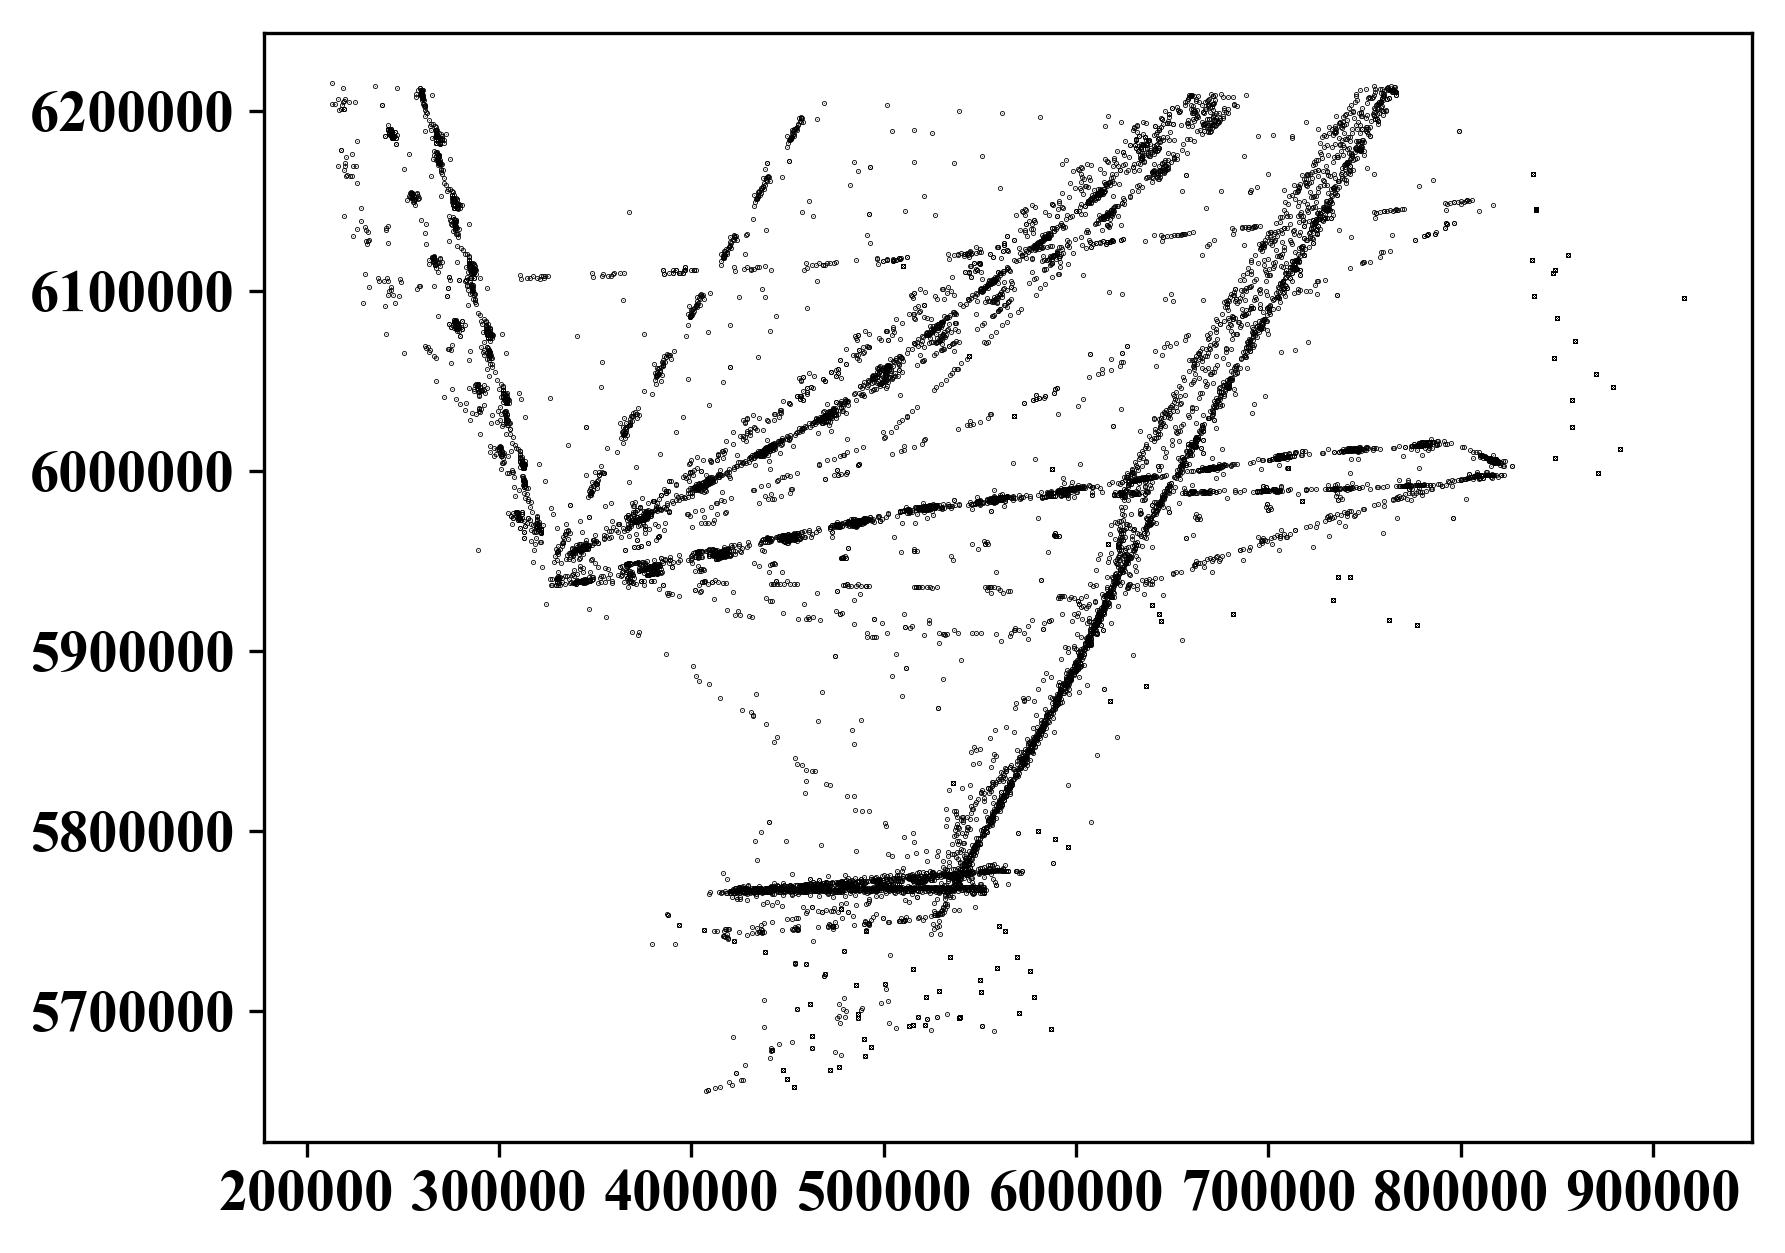

In [6]:
PyPlot.plot(lons, lats, "ko", markersize=0.2)
PyPlot.show()

## Conversion of coordinates
We have to go from `EPSG:32361` to `WGS84`.     
We define these two projections and apply the `transform` function.

In [7]:
function transform_coords(lon::Array, lat::Array)
    
    # Setup projections
    wgs84 = Projection("+proj=longlat +datum=WGS84 +no_defs")
    espgs32361 = Projection("+proj=utm +zone=31 +north +datum=WGS84 +units=m +no_defs")
    
    # Allocate
    npoints = length(lons)
    lonp = Array{Float64, 1}(undef, npoints)
    latp = Array{Float64, 1}(undef, npoints)
    
    # Loop
    for i = 1:npoints
        lonp[i], latp[i], e = transform(espgs32361, wgs84, [lon[i], lat[i], 0.])
    end
    
    return lonp, latp
end

transform_coords (generic function with 1 method)

In [8]:
lon, lat = transform_coords(lons, lats);

In [9]:
function decorate_map(ax)
    PyPlot.grid(linewidth=0.2)
    ax.add_feature(coast, color=".6", 
            edgecolor="k", zorder=5)
        
    ax.set_xlim(-2., 9.)
    ax.set_ylim(51., 56)
    ax.set_xticks(-2:2.:9.)
    ax.set_yticks(51.:1:56.)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

end

decorate_map (generic function with 1 method)

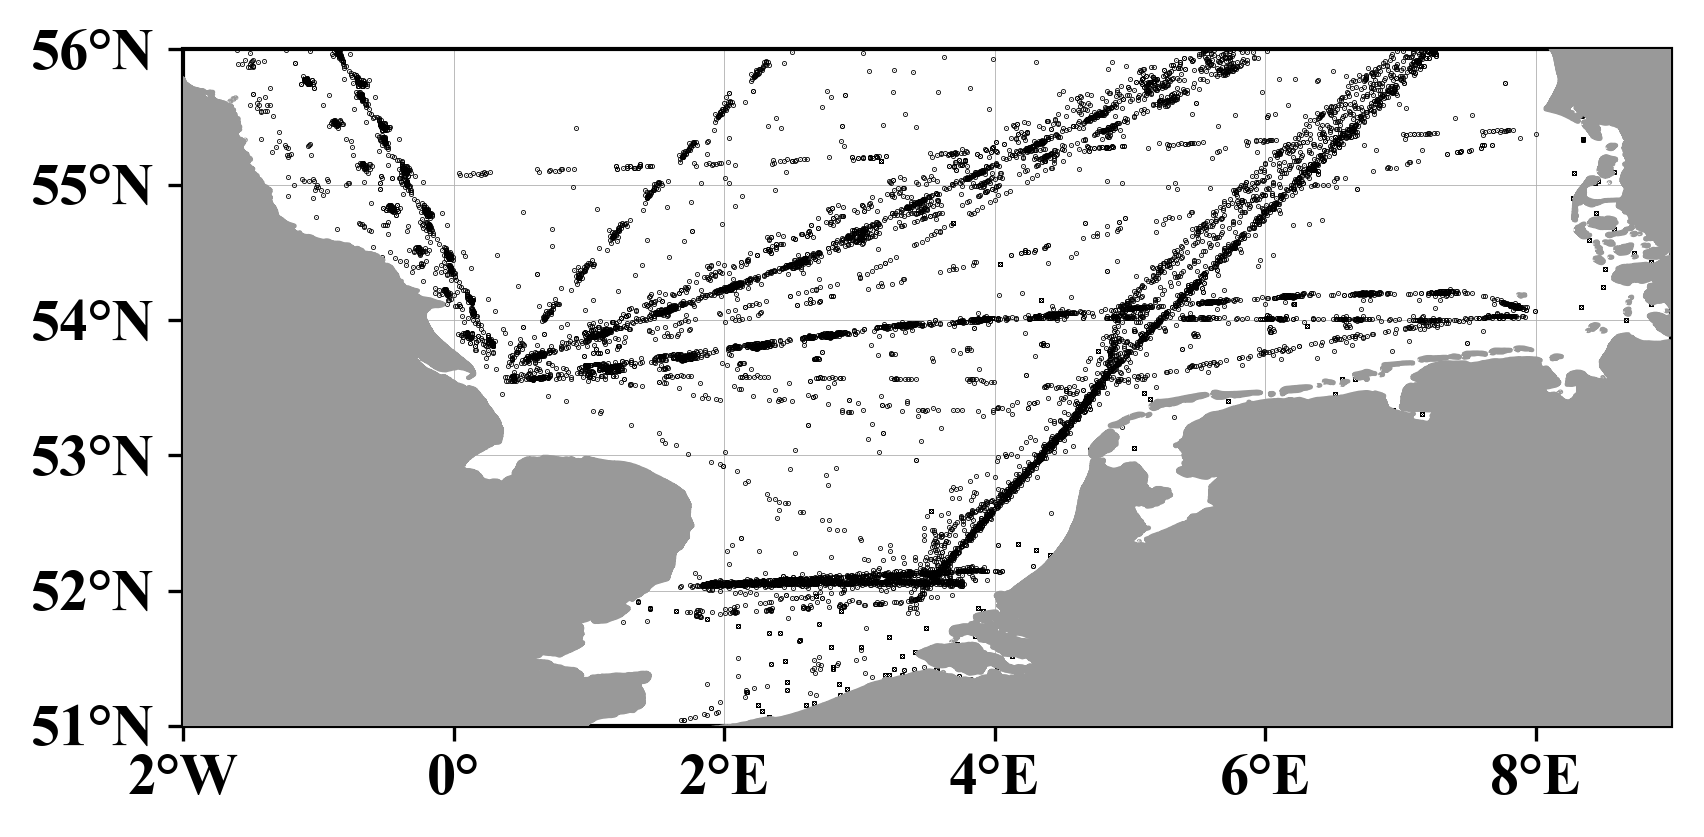

In [10]:
fig = PyPlot.figure()
ax = PyPlot.subplot(111, projection=myproj)

ax.plot(lon, lat, "ko", markersize=.2)
decorate_map(ax)

#PyPlot.savefig(joinpath(figdir, "drifter_positions_qc_release.png"), 
#    dpi=300, bbox_inches="tight")
PyPlot.show()
#PyPlot.close()

### Plot presence/absence

In [11]:
data_presence = occurs .== 1;
data_absence = .!(data_presence);

In [12]:
fig = PyPlot.figure(figsize=(8, 8))
ax = PyPlot.subplot(211, projection=myproj)
ax.plot(lon[data_presence], lat[data_presence], "ko", markersize=.2)
title("Presence")
decorate_map(ax)

ax = PyPlot.subplot(212, projection=myproj)
ax.plot(lon[data_absence], lat[data_absence], "ko", markersize=.2)
title("Absence")
decorate_map(ax)
PyPlot.savefig(joinpath(figdir, "data_presence_absence.png"), 
    dpi=300, bbox_inches="tight")
#PyPlot.show()
PyPlot.close()

## Prepare mask

In [13]:
bathname = "/data/GEBCO/gebco_30sec_4.nc"

if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/ACcxUEZZi6a4ziR/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[13]:6


In [14]:
bx, by, b = load_bath(bathname, true, longrid, latgrid)
@show size(b)

size(b) = (121, 51)


(121, 51)

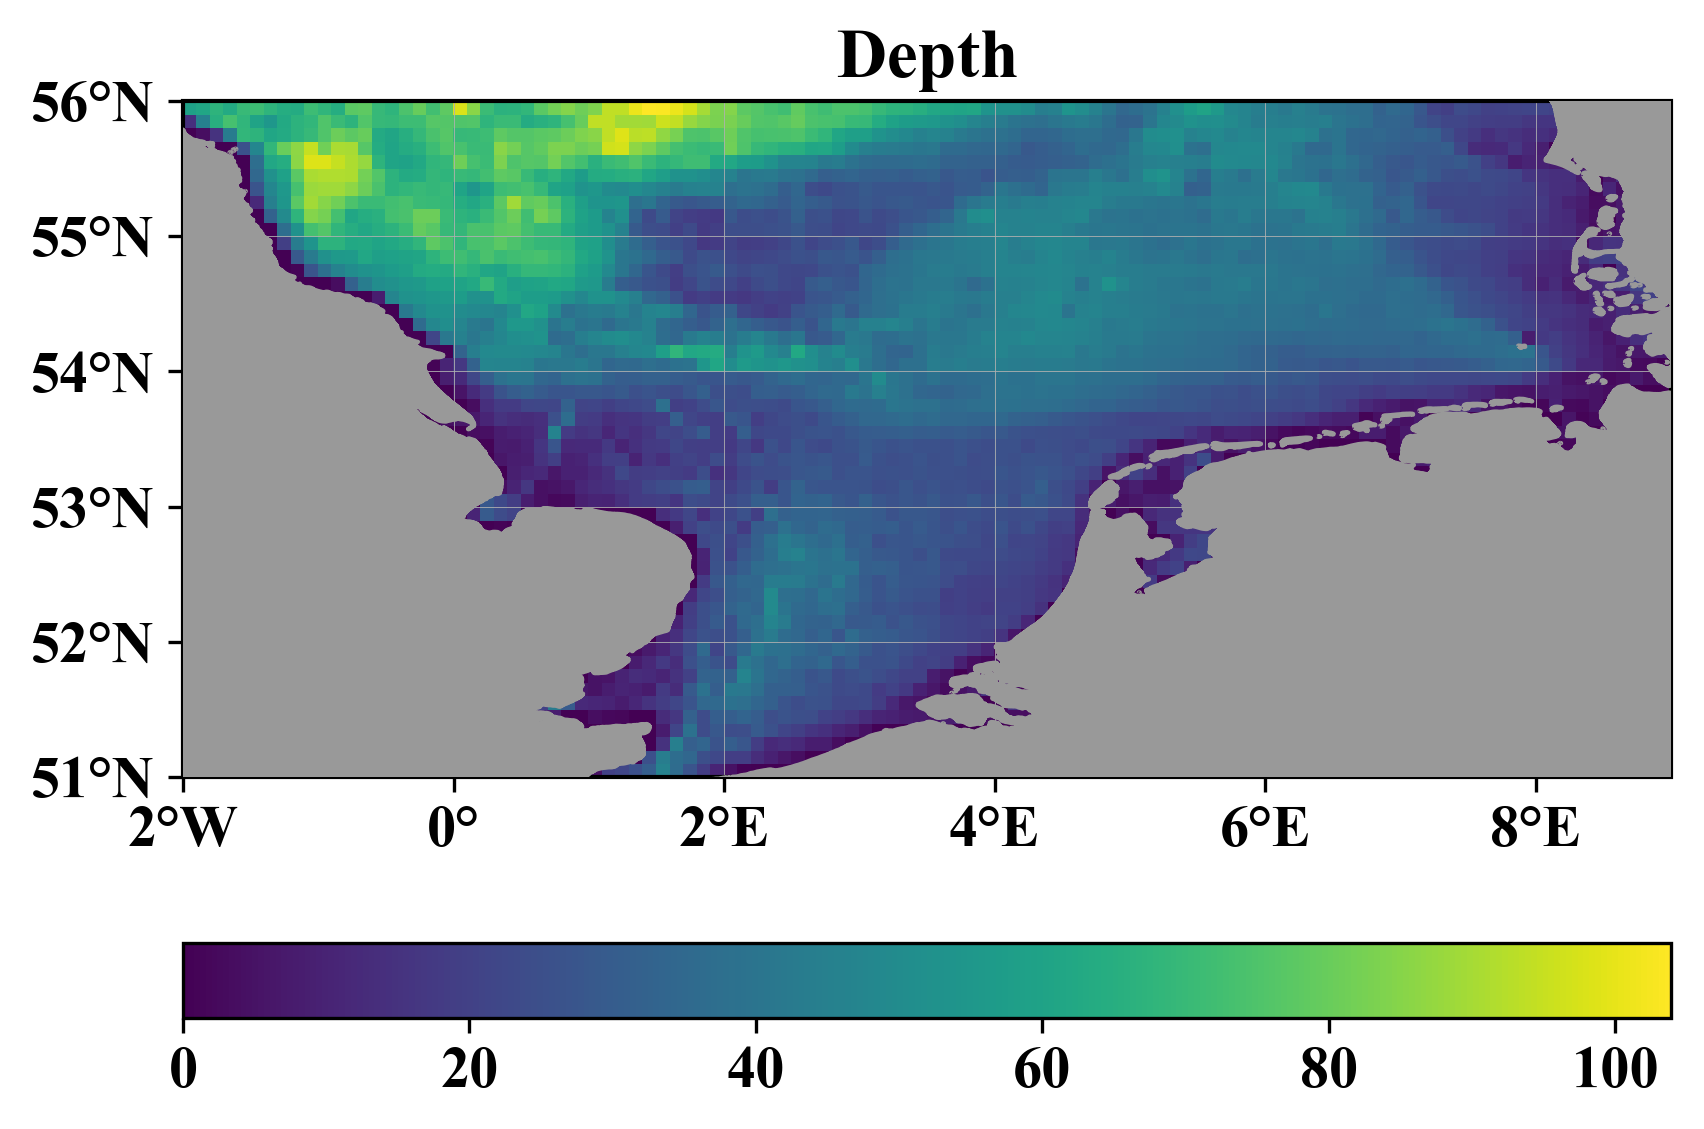

In [15]:
fig = PyPlot.figure()
ax = PyPlot.subplot(111, projection=myproj)
pcolor(bx,by,b', vmin=0.); 
colorbar(orientation="horizontal")
title("Depth")
decorate_map(ax)

### Metrics

In [16]:
mask, (pm, pn),(xi, yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid);

In [17]:
xi, yi, mask = DIVAnd.load_mask(bathname, true, longrid, latgrid, 0.0)

(-2.0:0.1:10.0, 51.0:0.1:56.0, Bool[0 0 … 1 1; 0 0 … 1 1; … ; 0 0 … 0 0; 0 0 … 0 0])

In [18]:
xx, yy = ndgrid(xi, yi);

## Compute heatmap

In [19]:
inflation = ones(length(lon));
@time dens1, LHM, LCV, LSCV = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon, lat), inflation, 0.2);
@time dens2, LHM, LCV, LSCV = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon[data_presence], lat[data_presence]), inflation, 0.2);
@time dens3, LHM, LCV, LSCV = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon[data_absence], lat[data_absence]), inflation, 0.2);

┌ Warning: Data array size (25777,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/IHslM/src/DIVAnd_heatmap.jl:48


 21.993378 seconds (50.65 M allocations: 3.575 GiB, 6.30% gc time)


┌ Warning: Data array size (25777,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/IHslM/src/DIVAnd_heatmap.jl:48


  0.532330 seconds (302.59 k allocations: 727.678 MiB, 7.14% gc time)


┌ Warning: Data array size (25777,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/IHslM/src/DIVAnd_heatmap.jl:48


  0.748290 seconds (698.76 k allocations: 1.012 GiB, 4.60% gc time)


In [35]:
function plot_heatmap(lon, lat, dens, titletext, figname)
    myproj = ccrs.PlateCarree()
    fig = PyPlot.figure(figsize=(12,8))
    ax = PyPlot.subplot(111, projection=myproj)
    ax.plot(lon, lat, "ko", markersize=0.2)
    pcm = ax.pcolormesh(xx, yy, dens, cmap=PyPlot.cm.hot_r)
    colorbar(pcm, orientation="horizontal", extend="max")
    decorate_map(ax)
    title(titletext)
    PyPlot.savefig(figname, dpi=300, bbox_inches="tight")
    PyPlot.close()
end

plot_heatmap (generic function with 1 method)

In [36]:
plot_heatmap(lon[data_presence], lat[data_presence], dens2,
    "Heatmap with 'presence' data points", joinpath(figdir, "heatmap_presence.png"))
plot_heatmap(lon[data_absence], lat[data_absence], dens3,
    "Heatmap with 'absence' data points", joinpath(figdir, "heatmap_absence.png"))
plot_heatmap(lon, lat, dens1,
    "Heatmap with all data points", joinpath(figdir, "heatmap_all.png"))

In [37]:
plot_heatmap(lon[data_presence], lat[data_presence], dens2 ./ (dens2.+dens3),
    "Relative heatmap (presence/presence+absence)", joinpath(figdir, "heatmap_relative.png"))